<img src='../../media/common/LogoWekeo_Copernicus_RGB_0.png' align='left' height='96px'></img>

<hr>

# Model Selection for Grassland Classification



This notebook will demonstrate how to use the data to train, evaluate and select a model for a machine learning application. 

The task is to train a model which can classify grassland areas in the Netherlands. The ultimate goal would be to classify grasslands yearly to derive change maps of grassland loss and gain from them. To do the classification we are using phenological data and the EuroCrops Dataset as ground truth.

This notebook uses data that was already downloaded and prepared for R in the previous notebook.

### Environment Setup

Before we begin, we need to prepare our environment by importing the necessary R packages.

In [1]:
# Define the list of required packages
required_packages <- c(
  # Multi-core processing
  "doParallel",
  
  # Data handling
  "dplyr", "lubridate", "gridExtra",
  
  # Machine Learning
  "caret", "naivebayes", "lightgbm", "scales",
  "glmnet", "randomForest", "kernlab", "pROC", "MLmetrics",
    
  # hdar data access
  "hdar"
)

In [2]:
# load packages
load_required_packages <- function(pkg) 
{
  library(pkg, character.only = TRUE)  # Load the package
}
  
# Iterate over the list of required packages
invisible(sapply(required_packages, load_required_packages))

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: ggplot2

Loading required package: lattice

naivebayes 1.0.0 loaded

For more information please visit: 

https://majkamichal.github.io/naivebayes/

Loading required package: Matrix

Loaded glmnet 4.1-8

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:gridE

In [3]:
# Load the data prepared in the previous notebook

setwd("~/wekeo4land") 

random_points <- readRDS('data/processing/ml-grassland-classification/random_points.rds')

<hr>

## Separating Training and Validation Dataset

In [4]:
# Set seed for reproducibility
set.seed(123) 

# Define split ratio (e.g., 70% for training, 30% for validation)
split_ratio <- 0.7

# Create random indices for calibration dataset
cal_indices <- sample(seq_len(nrow(random_points)), size = floor(split_ratio * nrow(random_points)))

# Split the dataset
train_dat <- random_points[cal_indices, ]   # Training dataset
val_dat   <- random_points[-cal_indices, ]  # Validation dataset

In [5]:
# Split train_dat into predictors and response
x_train <- train_dat %>% select(-Class)  # predictor
y_train <- train_dat$Class               # Response (as a vector)

# Ensure y_train is a factor for classification tasks
y_train <- as.factor(y_train)

<hr>

## Model Training

Here we are testing quite a few different algorithms on their performance for the task. 
It has to be noted that this is a quite naive and brute force approach to the task, since the models hyperparameters aren't tweaked and no pre-selection of machine learning algorithms based on expert knowledge is made. 

However it will give a rough idea on the performance of the algorithms and in addition it will provide information on the computational efficiency of the algorithms in terms of memory usage and computation time. These are also important parameters to consider when scaling the model up.

In [6]:
models <- {}

# Metrics initialization
accuracy <- list()
precision <- list()
recall <- list()
f1 <- list()
time_usage <- list()

# Logistic Regression
start_time <- Sys.time()
models[["Logistic Regression"]] <- train(x_train, y_train,
  method = "glmnet",
  trControl = trainControl(method = "cv", number = 10, allowParallel = TRUE),
  tuneGrid = expand.grid(alpha = 0, lambda = seq(0.001, 0.1, by = 0.001))
)
time_usage[["Logistic Regression"]] <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))

# Support Vector Machines
start_time <- Sys.time()
models[["Support Vector Machines"]] <- train(x_train, y_train,
  #data = train_data,
  method = "svmLinear",
  trControl = trainControl(method = "cv", number = 10, allowParallel = TRUE)
)
time_usage[["Support Vector Machines"]] <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))

# Decision Trees
start_time <- Sys.time()
models[["Decision Trees"]] <- train(x_train, y_train,
  # data = train_data,
  method = "rpart",
  trControl = trainControl(method = "cv", number = 10, allowParallel = TRUE),
  tuneLength = 10
)
time_usage[["Decision Trees"]] <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))

# Naive Bayes
start_time <- Sys.time()
models[["Naive Bayes"]] <- train(x_train, y_train,
  # data = train_data,
  method = "naive_bayes",
  trControl = trainControl(method = "cv", number = 10, allowParallel = TRUE),
  tuneLength = 10
)
time_usage[["Naive Bayes"]] <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))

# K-Nearest Neighbors
start_time <- Sys.time()
models[["K-Nearest Neighbor"]] <- train(x_train, y_train,
  #  data = train_data,
   method = "knn",
   trControl = trainControl(method = "cv", number = 10, allowParallel = TRUE),
   #tuneGrid = expand.grid(k = c(seq(5, 15, by = 2))),  # Include k = 1
   preProcess = c("center", "scale")  # Ensure data is scaled
 )
 time_usage[["K-Nearest Neighbor"]] <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))

# Random Forest
start_time <- Sys.time()
models[["Random Forest"]] <- train(x_train, y_train,
  method = "rf",
  trControl = trainControl(method = "cv", number = 10, allowParallel = TRUE),
  tuneGrid = expand.grid(mtry = seq(1, ncol(x_train), by = 2))  # Customize mtry values
)
time_usage[["Random Forest"]] <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))

# LightGBM
train_lightgbm <- function(x_train, y_train, custom_params = list()) {

  params <- list(
    objective = "binary",
    metric = "binary_error",
    feature_fraction = 1,
    learning_rate = 0.02,
    num_leaves = 25
  )

  params <- modifyList(params, custom_params)

  lgb.train(
    params = params,
    data = lgb.Dataset(data = as.matrix(x_train), label = as.numeric(as.character(y_train))),
    nrounds = 100,
    verbose = 0
  )
}
start_time <- Sys.time()
models[["Lightgbm"]]     <- train_lightgbm(x_train, y_train)
time_usage[["Lightgbm"]] <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [7]:
# Split val_dat into predictors and response
x_val <- val_dat %>% select(-Class)  # predictor
y_val <- val_dat$Class               # response (as a vector)

# Ensure y_val is a factor for classification tasks
y_val <- as.factor(y_val)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



The best cutoff value is: 0.3031811 


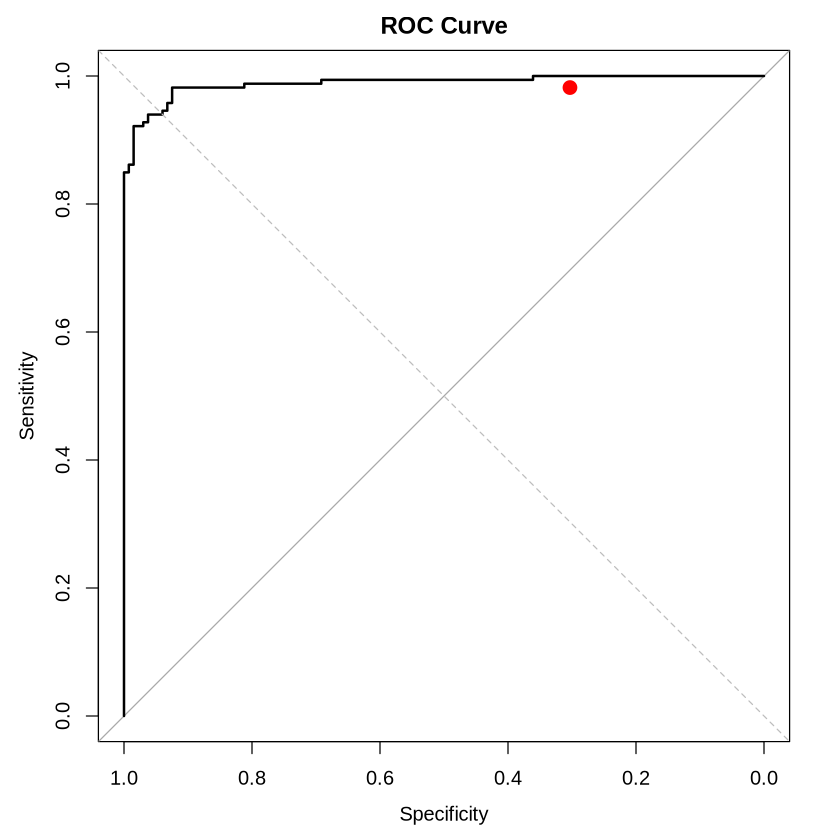

In [8]:
# LightGBM provides probabilities (ranging from 0 to 1) for belonging to each class. The following code adjusts the threshold to minimize the overall classification error.
# The resulting cutoff value is used afterwards. 
# Calculate best cutoff value for the Lightgbm prediction.

# Example: Assuming `predictions` is your predictor and `y_val` is the true binary response
predictions <- predict(models[["Lightgbm"]], as.matrix(x_val))
roc_curve <- roc(y_val ~ predictions)

# Find the cutoff that maximizes the Youden's J statistic
best_cutoff <- as.numeric(coords(roc_curve, "best", ret = "threshold", best.method = "youden"))

plot(roc_curve, main = "ROC Curve")
abline(a = 0, b = 1, lty = 2, col = "gray")  # Reference line
points(coords(roc_curve, "best")["threshold"], coords(roc_curve, "best")["sensitivity"],
       col = "red", pch = 19, cex = 1.5)

# Print the best cutoff value
cat("The best cutoff value is:", best_cutoff, "\n")

In [9]:
# Loop through model types and evaluate performance
for (key in names(models)) 
{
  cm <- NULL
  predictions <- NULL

  if (key == "Lightgbm") 
  {
    # LightGBM predictions
    predictions <- predict(models[[key]], as.matrix(x_val))
    predictions <- factor(ifelse(predictions > best_cutoff, 1, 0), levels = c(0, 1))
    cm <- caret::confusionMatrix(predictions, y_val)
  } else if (key %in% c("K-Nearest Neighbor", "Support Vector Machines", "Random Forest")) 
  {
    # Handle incomplete cases for these models
    valid_idx   <- complete.cases(x_val)
    predictions <- predict(models[[key]], x_val[valid_idx, ])
    cm <- caret::confusionMatrix(predictions, y_val[valid_idx])
  } else 
  {
    # Other models
    predictions <- predict(models[[key]], x_val)
    cm <- caret::confusionMatrix(predictions, y_val)
  }

  # Store metrics
  accuracy[[key]]  <- cm$overall["Accuracy"]
  precision[[key]] <- cm$byClass["Precision"]
  recall[[key]]    <- cm$byClass["Recall"]
  f1[[key]]        <- cm$byClass["F1"]

  # Print results
  cat(sprintf(
    "Model: %s\nAccuracy: %.3f\nPrecision: %.3f\nRecall: %.3f\nF1: %.3f\nTime: %.2f s\n\n",
    key, accuracy[[key]], precision[[key]], recall[[key]], f1[[key]], time_usage[[key]]
  ))
}

Model: Logistic Regression
Accuracy: 0.950
Precision: 0.921
Recall: 0.970
F1: 0.945
Time: 1.58 s

Model: Support Vector Machines
Accuracy: 0.943
Precision: 0.939
Recall: 0.932
F1: 0.936
Time: 0.96 s

Model: Decision Trees
Accuracy: 0.953
Precision: 0.941
Recall: 0.955
F1: 0.948
Time: 0.50 s

Model: Naive Bayes
Accuracy: 0.963
Precision: 0.977
Recall: 0.940
F1: 0.958
Time: 0.40 s

Model: K-Nearest Neighbor
Accuracy: 0.970
Precision: 0.963
Recall: 0.970
F1: 0.966
Time: 0.58 s

Model: Random Forest
Accuracy: 0.963
Precision: 0.962
Recall: 0.955
F1: 0.958
Time: 21.19 s

Model: Lightgbm
Accuracy: 0.957
Precision: 0.976
Recall: 0.925
F1: 0.950
Time: 3.71 s



<hr>

## Model Evaluation

#### Metrics

In [10]:
plot_dict <- function(data, title, x_label, y_label) {
  # Convert input data to a data frame
  df <- data.frame(metric = as.numeric(unlist(data)), model = names(data))
  
  # Sort the DataFrame by the metric column
  df$model <- factor(df$model, levels = df$model[order(-df$metric)])

  # Create the plot
  ggplot(df, aes(x = metric, y = model)) +
    geom_bar(stat = "identity", aes(fill = metric), show.legend = FALSE) +
    scale_fill_gradient(low = "lightgreen", high = "darkgreen") +
    coord_cartesian(xlim = c(min(df$metric) * 0.999, max(df$metric) * 1.001)) + # Adjust the view without dropping data
    theme_minimal() +
    labs(title = title, x = x_label, y = y_label) +
    theme(
      plot.title = element_text(hjust = 0.5, size = 20),
      axis.title.x = element_text(size = 16),
      axis.title.y = element_text(size = 16),
      axis.text = element_text(size = 14)
    )
}

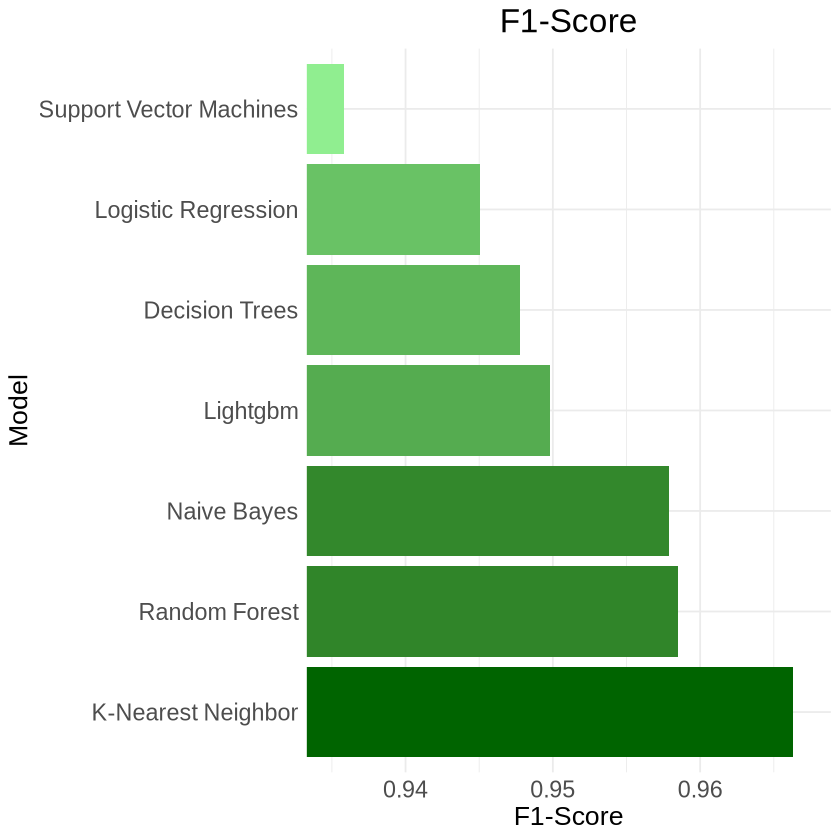

In [11]:
plot_dict(f1, 'F1-Score', 'F1-Score', 'Model')

#### Execution Time

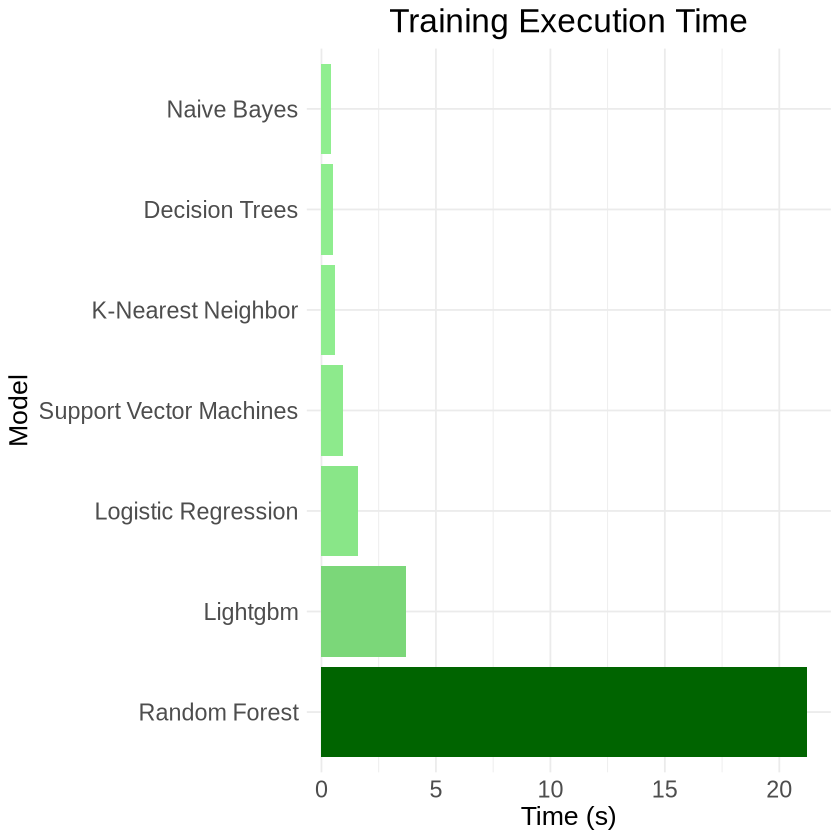

In [12]:
plot_dict(time_usage, 'Training Execution Time', 'Time (s)', 'Model')

#### Confusion Matrix

A confusion matrix is a table that summarizes the performance of a classification model by comparing the predicted labels with the true labels of a set of data. 

The confusion matrix consists of four values: true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN). The rows of the matrix represent the actual labels, while the columns represent the predicted labels. The diagonal elements of the matrix represent the instances that are classified correctly, while the off-diagonal elements represent the instances that are misclassified.

In [13]:
plot_confusion_matrices <- function(models, X_test, y_test) {
    num_models <- length(models)
    nrows <- ceiling(num_models / 3)
    ncols <- min(num_models, 3)
    plots <- list()

    class_names <- c("Grassland", "No Grassland")
    references  <- factor(y_test)

    for (key in names(models)) 
    {
        model <- models[[key]]

        predictions <- predict(model, as.matrix(X_test))

        if (key == "Lightgbm")
        {
            predictions <- factor(ifelse(predictions > best_cutoff, 1, 0))
        }
        cm <- confusionMatrix(predictions, references)

        cm_normalized     <- prop.table(cm$table, 1)
        cm_data           <- as.data.frame(cm_normalized)
        colnames(cm_data) <- c("True", "Predicted", "Freq")
        cm_data$Freq[is.na(cm_data$Freq)] <- 0

        p <- ggplot(cm_data, aes(y = Predicted, x = True, fill = Freq)) +
            coord_equal() +
            geom_tile() +
            geom_text(aes(label = sprintf("%.2f", Freq))) +
            scale_fill_gradient(low = "white", high = "darkgreen") +
            scale_x_discrete(labels = class_names) +
            scale_y_discrete(labels = class_names) +
            labs(title = key, y = "True labels", x = "Predicted labels", ) +
            theme_minimal() +
            theme(legend.position = "none")

        plots[[key]] <- p
    }

    grid.arrange(grobs = plots, nrow = nrows, ncol = ncols)
}

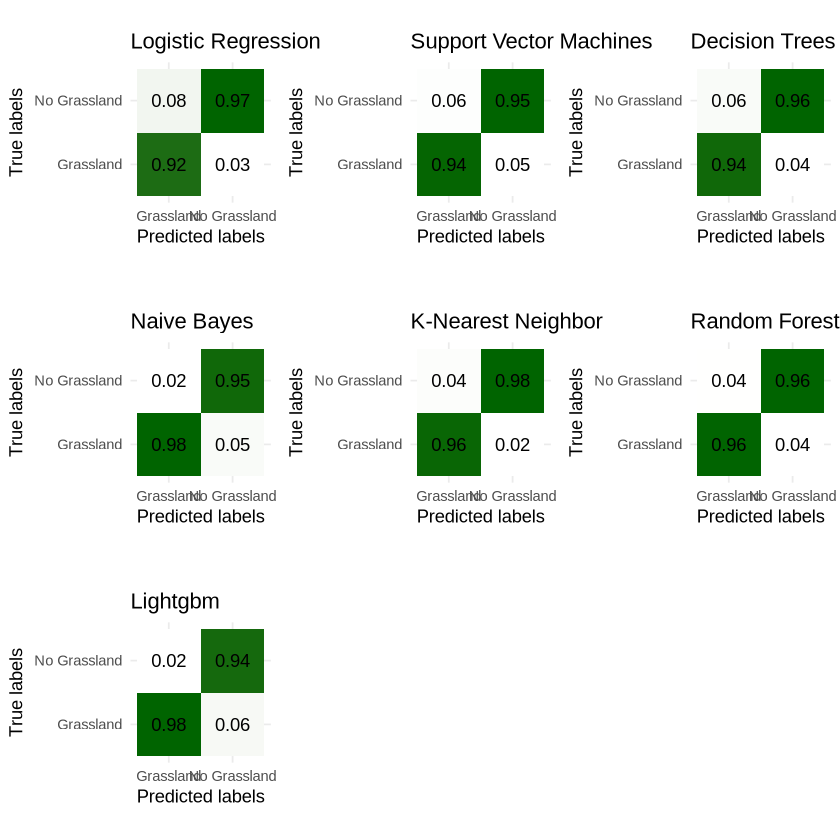

In [14]:
plot_confusion_matrices(models, x_val, y_val)

<p><img src='../../media/land/all_partners_wekeo_2.png' align='left' alt='Logo EU Copernicus' height='400px'></img></p>